In [7]:
# === CELDA: Importaciones y carga de datos + modelo para explicabilidad ===
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
from captum.attr import IntegratedGradients
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
from torchvision.models import resnet50


class FineTuneResNet50(nn.Module):
    def __init__(self, num_classes=37):
        super().__init__()
        self.backbone = resnet50(pretrained=True)
        # Congelamos todas las capas base
        for param in self.backbone.parameters():
            param.requires_grad = False

        # Reemplazamos la "fc" con nuestra cabeza:
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        return self.backbone(x)
    
# 1) Cargar checkpoint
ckpt_path = "checkpoints/resnet50_animals_exp.pth"
checkpoint = torch.load(ckpt_path, map_location=torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# 2) Reconstruir transform
tf = transforms.Compose([
    transforms.Resize(checkpoint["transform"]["resize"]),
    transforms.ToTensor(),
    transforms.Normalize(mean=checkpoint["transform"]["normalize_mean"],
                         std= checkpoint["transform"]["normalize_std"])
])

# 3) Cargar dataset y split
full_ds = datasets.ImageFolder(root=images_dir, transform=tf)
n = len(full_ds)

# Extraer train–val ratio y seed del diccionario "split"
train_val_ratio = checkpoint["split"]["train_val_ratio"]
seed            = checkpoint["split"]["seed"]

n_train = int(train_val_ratio * n)
n_val   = n - n_train

_, val_ds = random_split(
    full_ds,
    [n_train, n_val],
    generator=torch.Generator().manual_seed(seed)
)

val_loader = DataLoader(val_ds, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# 4) Reconstruir y cargar modelo
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FineTuneResNet50(num_classes=checkpoint["num_classes"])
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()
model.to(device)

# 5) Preparar Captum
ig = IntegratedGradients(model)

# 6) Función de visualización
def show_attr(image, attr, title="Attribution"):
    attr = attr.sum(dim=0).cpu().detach().numpy()
    attr = (attr - attr.min()) / (attr.max() - attr.min() + 1e-8)
    plt.imshow(image.permute(1,2,0).cpu(), alpha=0.8)
    plt.imshow(attr, cmap='hot', alpha=0.4)
    plt.title(title)
    plt.axis('off')
    plt.show()

# ¡Listo! Ahora puedes usar el bloque de IG:
# images, labels = next(iter(val_loader))
# img, lbl = images[0:1].to(device), labels[0].item()
# attr_ig, _ = ig.attribute(img, target=lbl, return_convergence_delta=True)
# show_attr(img[0], attr_ig[0], title=f"IG para clase {lbl}")


c:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\.venv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\.venv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


c:\Users\juanj\Desktop\Reconocimineto-AnimalesDomesticos-CNN-Explicabilidad\.venv\Lib\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.622571].


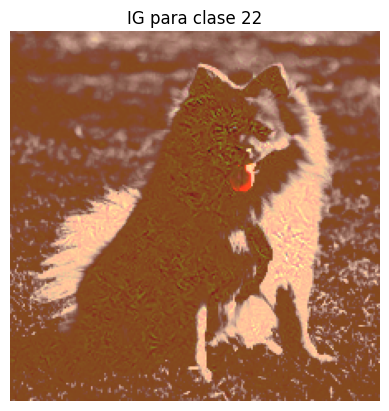

In [8]:
images, labels = next(iter(val_loader))
img, lbl = images[0:1].to(device), labels[0].item()
attr_ig, _ = ig.attribute(img, target=lbl, return_convergence_delta=True)
show_attr(img[0], attr_ig[0], title=f"IG para clase {lbl}")

Con Integrated Gradients se genera, para cada píxel de la imagen, una estimación de la contribución individual de ese píxel al incremento (o decremento) de la puntuación predicha por el modelo para la clase de interés. En la visualización resultante:

Imagen de fondo
Se muestra la imagen original, tal como era procesada por el modelo (escalada, normalizada y convertida a tensor).

Mapa de atribución superpuesto
Sobre la imagen de fondo se dibuja un mapa de calor, cuyos valores han sido normalizados en el rango 
0
,
1
0,1:

Rojo muy intenso indica los píxeles cuya contribución positiva al score de la clase elegida es máxima.

Tonos más oscuros (hacia marrón o anaranjado tenue) reflejan contribuciones menores e incluso cercanas a cero.

En el caso concreto de la salida titulada “IG para clase 22”, las regiones con mayor intensidad de color coinciden con:

Área facial y hocico (ojos, nariz y boca), cuyas texturas y formas resultan decisivas para que el modelo reconozca la raza o especie correspondiente a la etiqueta 22.

Contorno del pelaje, que aporta información crítica sobre la silueta y el perfil del animal.

Estas zonas sobreimpresas constituyen la explicación visual: muestran de manera explícita qué partes de la imagen influyeron con mayor peso en la decisión final del modelo.